# はじめに

このノートではLightGBMを理解するために、下記のmeanxaiの動画を参考にしながら、LightGBMのアルゴリズムについて理解を深める。

- [[MXML-12-01] Light GBM [1/5] - Histogram-based split finding](https://www.youtube.com/watch?v=N39NE4Nj6vc&list=PLQXYdeUrQvu5z2hYI6TTiqBLCq7qWJ45n)

今回は、Histogram-based split findingに焦点をあてる。

## Histogram-based split findingアルゴリズム

Histogram-based split findingアルゴリズムは、ヒストグラムを利用して最適な分割点を高速に計算する。アルゴリズムの手順をまとめる前に、下記のような簡単なデータを使って、このアルゴリズムのイメージを掴んでおく。

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

id =[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
x = [0.41, 0.22, 0.7 , 0.06, 0.48, 0.8 , 0.05, 0.72, 0.34, 0.15, 0.6 , 0.31, 0.01, 0.02, 0.29, 0.55, 0.53, 0.22, 0.4 , 0.98]
y = [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]
y0 = 0.5
# [0.5, 0.5, -0.5, 0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.5, -0.5, -0.5, 0.5, 0.5, -0.5, -0.5, -0.5, 0.5, 0.5, -0.5]
g = [-1*(v - y0) for v in y]
h = 0.5* (1-0.5)

ヒストグラムを使うアルゴリズムなので、$x$を0.2単位で分割し、ヒストグラムのもととなる表を作成する。

|Range|Bin|ID| $\sum$ g|
|:---|:---|:---|:---|
|0.0 $\le$ x $\lt$ 0.2|0|3,6,9,12,13|2.5|
|0.2 $\le$ x $\lt$ 0.4|1|1.8.11.14.17|0.5|
|0.4 $\le$ x $\lt$ 0.6|2|0,4,15,16,18|0.5|
|0.6 $\le$ x $\lt$ 0.8|3|2,7,10|-1.5|
|0.8 $\le$ x $\lt$ 1.0|4|5,19|-1.0|



ビンにアサインされたデータの$\sum$ gを計算し、分割点の候補を検討する。$y$軸は$g$である。ヒストグラムにして可視化するとわかりよい。このヒストグラムを見ると、各ビンの間を分割点の候補として検討できそうである。

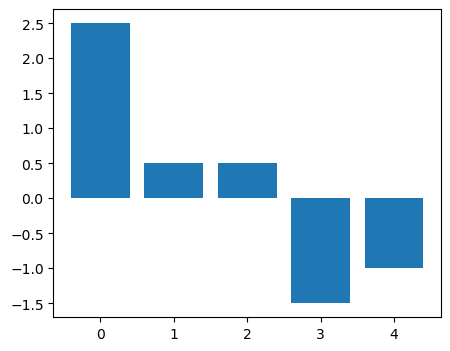

In [26]:
g_sum, bins = np.histogram(x, 5, weights=g)
plt.figure(figsize=(5, 4))
plt.bar(np.arange(0, g_sum.shape[0]), g_sum)
plt.show()

各候補となる分割点ごとにScoreを計算したのが下記である。最大のScoreを得られているのは0.6(ビン2とビン3の間)である。この分割点を観察するとわかるが、分割すると残差の方向性に偏りを発生させられるため、Scoreが大きくなりやすい。

$$
score = \frac{ (\sum_{i \in I_{L}} g_{i})^2 }{ \sum_{i \in I_{L}} h_{i} + \lambda}
$$


|Candidate|$\sum$ g (L)|$\sum$ g (R)| Score(L)| Score(R)| Score(L+R)|
|:---|:---|:---|:---|:---|:---|
|0.2|2.5|-1.5|2.5^2/(0.25*5)=5.0|(-1.5)^2/(0.25*15)=0.6|5.6|
|0.4|3.0|-2.0|3.0^2/(0.25*5)=3.6|(-2.0)^2/(0.25*10)=1.6|5.2|
|0.6|3.5|-2.5|3.5^2/(0.25*15)=3.27|(-2.5)^2/(0.25*5)=5.0|9.94|
|0.8|2.0|-1.0|2.0^2/(0.25*18)=0.89|(-1.0)^2/(0.25*2)=2.0|2.89|

XGboostでもApproximate Algorithm、Weighted Quantile Sketch for Split Findingなどが高速化のために提案されていたが、LightGBMでは高速化のためにHistogram-based split findingアルゴリズムが利用される。下記の画像を参考に、アルゴリズムの手順をまとめておく。

1. $x_{0},x_{1}$の各々でヒストグラムを作成する。$y$軸は各ビンごとの$g=-(y-\hat{y})$の合計。
2. ヒストグラムを利用し、Gainが最も高くなる分割点を探索する。(当たり前ながら、可視化されたヒストグラムを見ながら探すわけではない)
3. $x_{0},x_{1}$のGainが高くなる分割点を比較して、Gainが高くなる分割点を選ぶ

この方法はヒストグラムを大量に作成するため、計算コストが高い。そのため、並列化を行い高速化を行う。

<img src='./BoostHist.png'>


## Histogram-based split findingアルゴリズムの実装

In [ ]:
# --------------------------------
# $ python3 histogram-based.py
# --------------------------------
# histogram-based
import numpy as np
from sklearn.datasets import make_blobs
from multiprocessing.pool import Pool

# Create a training data set.
x, y = make_blobs(n_samples=300, n_features=2, centers=[[0., 0.], [0.5, 0.3]], cluster_std=0.15, center_box=(-1., 1.))

def find_local_split_point(f, s_point, g, h, G, H, r, p_score):
  """
  f: 特徴量ベクトル x[:,0], x[:,1]
  s_point: 分割点リスト
  """
  GL = HL = 0.0
  l_bound = -np.inf   
  max_gain = -np.inf 

  # jは候補点
  for j in s_point:
    # 左右の葉にjを基準に割り振る
    left  = np.where(np.logical_and(f > l_bound, f <= j))[0]
    right = np.where(f > j)[0]

    # 分割後に左右の葉でScoreを計算
    GL += g[left].sum()
    HL += (h[left] * (1. - h[left])).sum()
    GR = G - GL
    HR = H - HL
    # Gainを計算
    gain = (GL ** 2)/ (HL + r) + (GR ** 2)/(HR + r) - p_score
    
    # Gainが最大の点を探す
    if gain > max_gain: 
      max_gain = gain
      b_point = j 
    l_bound = j
  return b_point, max_gain

if __name__ == '__main__':
    y0 = np.ones(shape=y.shape) * 0.5 # 初期予測値
    g = -(y - y0)                     # 負の残差
    h = y0 * (1.0 - y0)               # ヘシアン

    # 各特徴量でベストな分割点を探す
    G = g.sum()
    H = h.sum()
    r = 0.0
    gamma = 0.0
    p_score = (G ** 2) / (H + r) # Scoreを計算

    # 各特徴量でヒストグラムを作成
    n_bin = 30 
    g0_parent, f0_bin = np.histogram(x[:, 0], n_bin, weights=g) # 特徴量0のヒストグラム
    g1_parent, f1_bin = np.histogram(x[:, 1], n_bin, weights=g) # 特徴量1のヒストグラム

    # 直列パーティションニングで並列化
    mp = Pool(2)
    args = [[x[:, 0], f0_bin], [x[:, 1], f1_bin]]
    ret = mp.starmap_async(find_local_split_point, [(x[:, 0], f0_bin, g, h, G, H, r, p_score), (x[:, 1], f1_bin, g, h, G, H, r, p_score)])

    mp.close()
    mp.join()

    results = ret.get()
    p1    = results[0][0]
    p2    = results[1][0]
    gain1 = results[0][1]
    gain2 = results[1][1]

    if gain1 > gain2:
        b_fid = 0
        b_point = p1
    else:
        b_fid = 1
        b_point = p2

    print('\nbest feature id =', b_fid)
    print( 'best split point =', b_point.round(3))

実行結果は下記の通り。特徴量0の0.298がベストな分割点となっている。

In [33]:
# best feature id = 0
# best split point = 0.298